# 🪠 Pipecleaning Simulations

In this notebook, we will cover more advanced MOSFET simulation and complete a task that all analog IC designers begin with when they encounter a new PDK: pipecleaning simulations. These are done to provide the parameters for the transistor models that analog designers use to intuitively navigate their design space:

🎥 Video Insight:

<iframe width="560" height="315" src="https://www.youtube.com/embed/HYjzjqk54hk?si=0JArH0DdcgYxyr8g" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

We'll use this as an opportunity to learn about both the models, as well as demonstrating how we extract the necessary parameters to use them in practice.

### Basic Transistor Operation: A Quick Recap

To ensure we're all on the same page, here's a concise summary of the video's insights:

| | Subthreshold | Strong Inversion | Mobility Degradation | 
| --- | --- | --- | --- |
| Region of validity | $V_{eff} \leq 0$ | $\dfrac{2nkT}{q} < V_{eff} < \dfrac{1}{2\theta}$ | $V_{eff} > \dfrac{1}{2\theta}$ |
| Drain current, $I_D$ | $I_{D0}\left(\dfrac{W}{L}\exp(qV_{eff}/nkT)\right)$ | $\dfrac12 \mu_n C_{ox}\dfrac{W}{L}V_{eff}^2$ | $\dfrac{\mu_n C_{ox} (W/L)V_{eff}^2}{2[1+(\theta V_{eff}^m)]^{1/m}}$ |
| Small-signal transconductance, $g_m$ | $\dfrac{qI_D}{nkT}$ | $\dfrac{2I_D}{V_{eff}} = \mu_n C_{ox} \dfrac{W}{L} V_{eff}$ | $\dfrac12 \mu_n C_{ox} \dfrac{W}{L\theta}$

The variables in question are described in the table below:

| Variable | Explanation |
| --- | --- |
| $ V_{eff} $ | Effective voltage across the transistor |
| $ V_{gs} $ | Gate-Source Voltage |
| $ V_{th} $ | Threshold Voltage |
| $ n $ | Subthreshold slope factor, typically around 1.5 for MOSFETs |
| $ kT $ | Thermal voltage, where $ k $ is the Boltzmann constant and $ T $ is the absolute temperature |
| $ q $ | Charge of an electron |
| $ \theta $ | Mobility degradation coefficient |
| $ I_{D0} $ | Drain current at the threshold voltage |
| $ W $ | Width of the transistor |
| $ L $ | Length of the transistor |
| $ I_D $ | Drain current |
| $ \mu_n $ | Electron mobility |
| $ C_{ox} $ | Oxide capacitance per unit area |
| $ g_m $ | Small-signal transconductance |
| $ m $ | Exponent in the mobility degradation equation, typically around 1.5 to 2.5 |
 
$V_{eff}$ is usually defined as $V_{gs}-V_{th}$, however in saturation it can take on the value of $V_{gs} - V_{th} - V_{ds}/2$, which takes into account channel width modulation.

Now, with our foundation set, let's dive into the heart of the matter!

### Computing $V_{th}$ and $g_m$: A Guided Exploration

Our journey begins with two pivotal parameters: $V_{th}$ and $g_m$. Extracting these values is a systematic process:

- **Device Selection**: Choose a range of devices that pique your interest.
- **Model-Based Testing**: Leverage our models to craft tests and pinpoint the desired values.

For instance, to unearth $V_{th}$, we'll keep $V_{ds}$ elevated and sweep through $V_{gs}$ across our chosen devices. This approach yields a $V_{gs}/I_D$ curve, enabling us to compute both $V_{th}$ and $g_m$.

##### 🧠 Exercises
1. Parameter Plotting: Can you plot the $V_{gs}/I_D$ curve for a selected device and identify the point corresponding to $V_{th}$?

2. Model Validation: Using the derived $V_{th}$ and $g_m$ values, simulate a basic MOSFET circuit. Do the results align with your expectations based on the model?

3. Deep Dive: Explore the impact of varying $V_{ds}$ on $V_{th}$. How does channel width modulation influence the effective voltage?

In [1]:
# Import the hdl21 library
import hdl21 as h
from hdl21.prefix import u
import vlsirtools.spice as vsp

# Import the SKY130 PDK
from sitepdks import *
import sky130_hdl21 as s
from sky130_hdl21 import primitives as p

# Import matplotlib for plotting
import matplotlib.pyplot as plt

# The minimum gate length of SKY130
min_gate_length = 0.15

# Three devices to characterize our MOSFETs
device1 = p.NMOS_1p8V_STD(w=15*min_gate_length, l=min_gate_length, nf=15)
device2 = p.NMOS_1p8V_STD(w=15*min_gate_length, l=2*min_gate_length, nf=15)
device3 = p.NMOS_1p8V_STD(w=15*min_gate_length, l=10*min_gate_length, nf=15)

# Stick 'em in a list
devices = [device2, device3]

def get_sim(device : h.Module) -> h.sim.Sim:

    @h.sim.sim
    class DeviceSim:

        @h.module
        class Tb:

            # Set up our ports
            VSS = h.Port()
            VDD = h.Signal()
            
            # Define our voltages
            vdd = h.DcVoltageSource(dc=1.8)(p=VDD, n=VSS)
            sweep = h.PulseVoltageSource(delay=0,
                                         v1=0,
                                         v2=1.8,
                                         period=1,
                                         rise=1,
                                         fall=1,
                                         width=1)(n=VSS)
            # Instantiate our device
            DUT = device(d=VDD, g=sweep.p, s=VSS, b=VSS)

        tran = h.sim.Tran(tstop=1,tstep=0.001)
        inc = s.install.include(h.pdk.Corner.TYP)

    return DeviceSim

opts = vsp.SimOptions(
            simulator=vsp.SupportedSimulators.NGSPICE,
            fmt=vsp.ResultFormat.SIM_DATA,
            rundir="./scratch",
        )

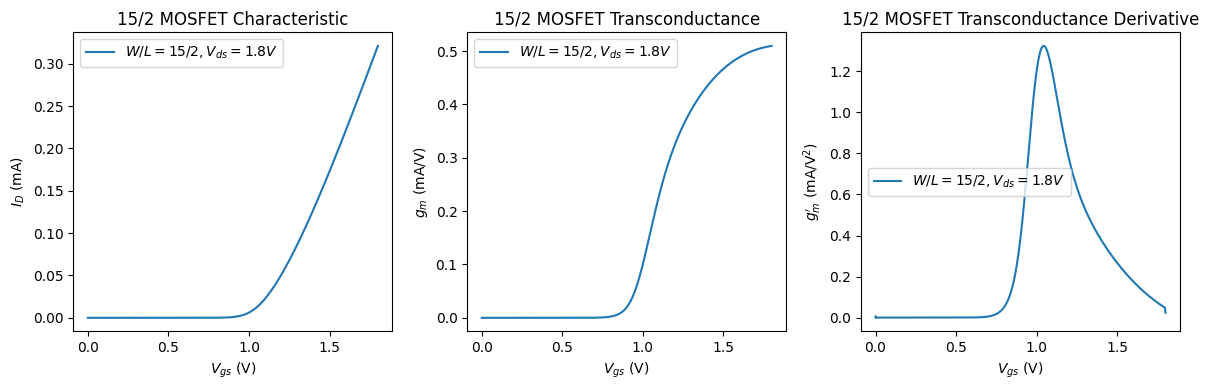

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Iterate over the devices and simulate
sim = get_sim(device=device2)
rvs = sim.run(opts=opts)

# Extract data
x = rvs.an[0].data['v(xtop.sweep_p)']
y = -rvs.an[0].data['i(v.xtop.vvdd)']*1000

# Compute the derivative
dy_dx = np.gradient(y, x)

# Plot the original data
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(x, y, label="$W/L=15/2, V_{ds} = 1.8V$")
plt.xlabel('$V_{gs}$ (V)')
plt.ylabel('$I_D$ (mA)')
plt.title('15/2 MOSFET Characteristic')
plt.legend()

# Plot the derivative
plt.subplot(1, 3, 2)
plt.plot(x, dy_dx, label="$W/L=15/2, V_{ds} = 1.8V$")
plt.xlabel('$V_{gs}$ (V)')
plt.ylabel('$g_m$ (mA/V)')
plt.title('15/2 MOSFET Transconductance')
plt.legend()

# Plot the second derivative
plt.subplot(1,3,3)
plt.plot(x, np.gradient(dy_dx, x), label="$W/L=15/2, V_{ds} = 1.8V$")
plt.xlabel('$V_{gs}$ (V)')
plt.ylabel("$g_m'$ (mA/V$^2$)")
plt.title('15/2 MOSFET Transconductance Derivative')
plt.legend() 


plt.tight_layout()
plt.show()


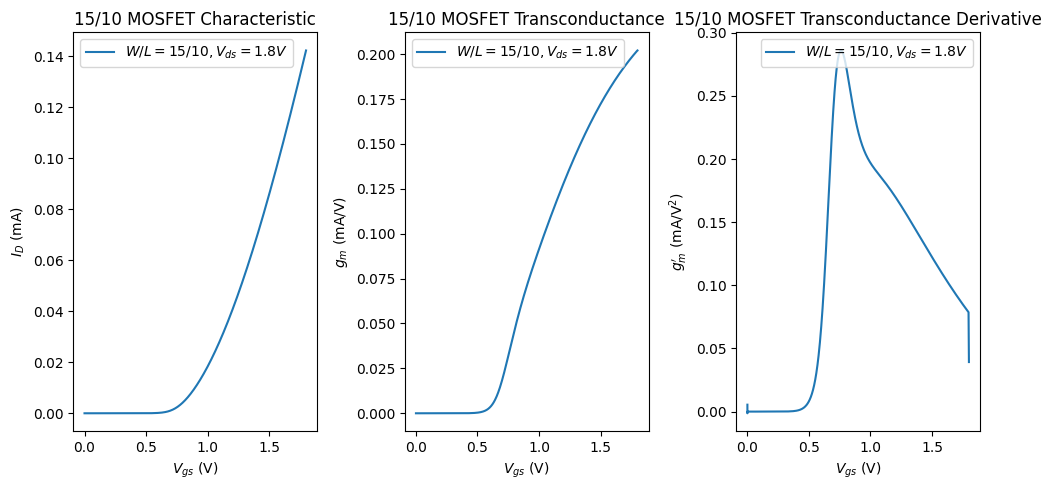

In [6]:
# Iterate over the devices and simulate
sim = get_sim(device=device3)
rvs = sim.run(opts=opts)

# Extract data
x = rvs.an[0].data['v(xtop.sweep_p)']
y = -rvs.an[0].data['i(v.xtop.vvdd)']*1000

# Compute the derivative
dy_dx = np.gradient(y, x)

# Plot the original data
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.plot(x, y, label="$W/L=15/10, V_{ds} = 1.8V$")
plt.xlabel('$V_{gs}$ (V)')
plt.ylabel('$I_D$ (mA)')
plt.title('15/10 MOSFET Characteristic')
plt.legend()

# Plot the derivative
plt.subplot(1, 3, 2)
plt.plot(x, dy_dx, label="$W/L=15/10, V_{ds} = 1.8V$")
plt.xlabel('$V_{gs}$ (V)')
plt.ylabel('$g_m$ (mA/V)')
plt.title('15/10 MOSFET Transconductance')
plt.legend()

# Plot the second derivative
plt.subplot(1,3,3)
plt.plot(x, np.gradient(dy_dx, x), label="$W/L=15/10, V_{ds} = 1.8V$")
plt.xlabel('$V_{gs}$ (V)')
plt.ylabel("$g_m'$ (mA/V$^2$)")
plt.title('15/10 MOSFET Transconductance Derivative')
plt.legend() 



plt.tight_layout()
plt.show()

### Decoding $C_{ox}$ and $V_{th}$ with $g_m$ Plots

Let's start with a visual treat! By inspecting the $g_m$ plots on the right, we can uncover some hidden gems. Notice that region with a sharp upward slope? That's the "strong inversion" zone when $V_{ds}=1.8V$. The slope itself reveals $\mu_n C_{ox} W/L$. With known values for $\mu_n$ and $W/L$, we're set to determine $C_{ox}$. And for the cherry on top, the x-intercept of this linear region hands us $V_{th}$ on a silver platter.

Running the numbers for the 15/2 case, we find:
- $V_{th}\simeq 0.9$
- $\mu_n C_{ox} W/L = 1.3 mA/V^2$
- $C_{ox} \simeq 0.17 \mu F/t_{ox}$

Switching gears to the 15/10 scenario:
- $V_{th}\simeq 0.7$
- $\mu_n C_{ox} W/L = 0.27 mA/V^2$
- $C_{ox} \simeq 0.18 \mu F/t_{ox}$

The results? Impressively consistent! The slight $V_{th}$ variation can be attributed to the nuances of channel width modulation.

### Journey to $r_{ds}$ and $\lambda$

Now, this is where things get a tad more challenging. But with our previous success, we're more than equipped! By running a simulation with a high $V_{gs}$ and sweeping $V_{ds}$, the resulting $I_{D}/V_{ds}$ curve and its derivative become our guiding stars to compute these values.

##### 🧠 Exercises:

1. **Plotting Adventure**: Can you generate the $I_{D}/V_{ds}$ curve for a selected device? What insights can you glean from its shape and inflection points?
  
2. **Parameter Hunt**: Using the derived $r_{ds}$ and $\lambda$ values, simulate a MOSFET circuit. How do the results align with your expectations based on the model?
  
3. **Deep Dive**: Explore the impact of varying $V_{gs}$ on $r_{ds}$. How does this variation influence the overall behavior of the MOSFET?

In [7]:
def get_sim(device : h.Module) -> h.sim.Sim:

    @h.sim.sim
    class DeviceSim:

        @h.module
        class Tb:

            # Set up our ports
            VSS = h.Port()
            VDD = h.Signal()
            
            # Define our voltages
            vdd = h.DcVoltageSource(dc=1.8)(p=VDD, n=VSS)
            sweep = h.PulseVoltageSource(delay=0,
                                         v1=0,
                                         v2=1.8,
                                         period=1,
                                         rise=1,
                                         fall=1,
                                         width=1)(n=VSS)
            # Instantiate our device
            DUT = device(d=sweep.p, g=VDD, s=VSS, b=VSS)

        tran = h.sim.Tran(tstop=1,tstep=0.001)
        inc = s.install.include(h.pdk.Corner.TYP)

    return DeviceSim

opts = vsp.SimOptions(
            simulator=vsp.SupportedSimulators.NGSPICE,
            fmt=vsp.ResultFormat.SIM_DATA,
            rundir="./scratch",
        )

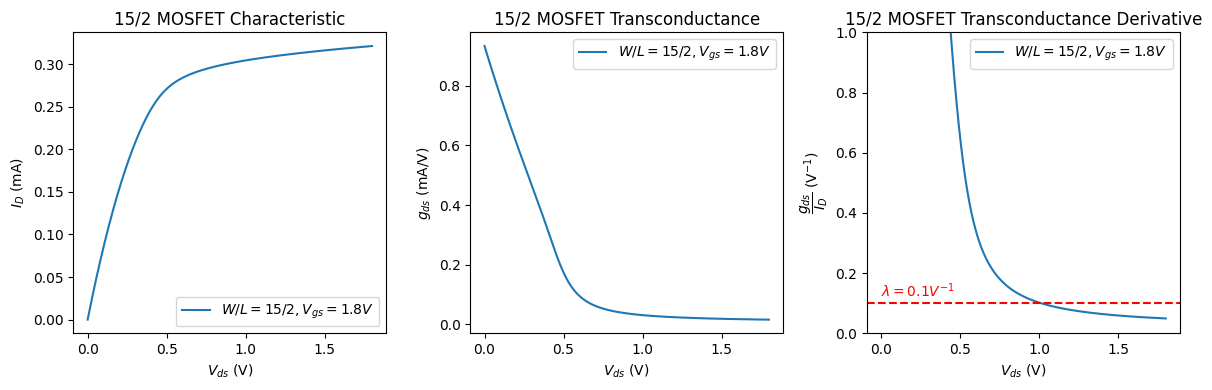

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Iterate over the devices and simulate
sim = get_sim(device=device2)
rvs = sim.run(opts=opts)

# Extract data
x = rvs.an[0].data['v(xtop.sweep_p)']
y = -rvs.an[0].data['i(v.xtop.vsweep)']*1000

# Compute the derivative
dy_dx = np.gradient(y, x)

# Plot the original data
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(x, y, label="$W/L=15/2, V_{gs} = 1.8V$")
plt.xlabel('$V_{ds}$ (V)')
plt.ylabel('$I_D$ (mA)')
plt.title('15/2 MOSFET Characteristic')
plt.legend()

# Plot the derivative
plt.subplot(1, 3, 2)
plt.plot(x, dy_dx, label="$W/L=15/2, V_{gs} = 1.8V$")
plt.xlabel('$V_{ds}$ (V)')
plt.ylabel('$g_{ds}$ (mA/V)')
plt.title('15/2 MOSFET Transconductance')
plt.legend()

# Plot the second derivative
plt.subplot(1,3,3)
plt.plot(x[1:], (dy_dx/y)[1:], label="$W/L=15/2, V_{gs} = 1.8V$")
plt.xlabel('$V_{ds}$ (V)')
plt.ylabel("$\dfrac{g_{ds}}{I_{D}}$ (V$^{-1}$)")
plt.title('15/2 MOSFET Transconductance Derivative')
plt.legend()

plt.ylim(0, 1)
plt.axhline(y=0.1, color='red', linestyle='--')
plt.text(0, 0.12, '$\lambda = 0.1 V^{-1}$', color='red')

plt.tight_layout()
plt.show()


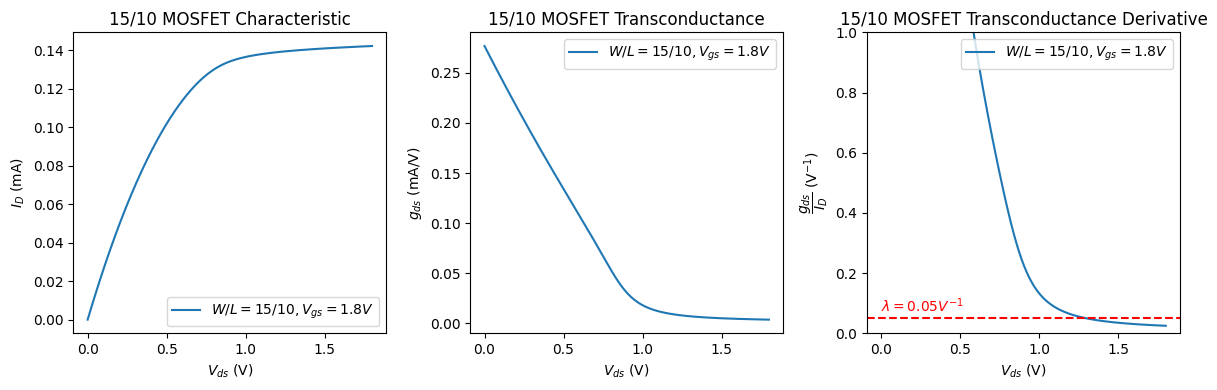

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Iterate over the devices and simulate
sim = get_sim(device=device3)
rvs = sim.run(opts=opts)

# Extract data
x = rvs.an[0].data['v(xtop.sweep_p)']
y = -rvs.an[0].data['i(v.xtop.vsweep)']*1000

# Compute the derivative
dy_dx = np.gradient(y, x)

# Plot the original data
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(x, y, label="$W/L=15/10, V_{gs} = 1.8V$")
plt.xlabel('$V_{ds}$ (V)')
plt.ylabel('$I_D$ (mA)')
plt.title('15/10 MOSFET Characteristic')
plt.legend()

# Plot the derivative
plt.subplot(1, 3, 2)
plt.plot(x, dy_dx, label="$W/L=15/10, V_{gs} = 1.8V$")
plt.xlabel('$V_{ds}$ (V)')
plt.ylabel('$g_{ds}$ (mA/V)')
plt.title('15/10 MOSFET Transconductance')
plt.legend()

# Plot the second derivative
plt.subplot(1,3,3)
plt.plot(x[1:], (dy_dx/y)[1:], label="$W/L=15/10, V_{gs} = 1.8V$")
plt.xlabel('$V_{ds}$ (V)')
plt.ylabel("$\dfrac{g_{ds}}{I_{D}}$ (V$^{-1}$)")
plt.title('15/10 MOSFET Transconductance Derivative')
plt.legend()

plt.ylim(0, 1)
plt.axhline(y=0.05, color='red', linestyle='--')
plt.text(0, 0.07, '$\lambda = 0.05 V^{-1}$', color='red')

plt.tight_layout()
plt.show()


These second-order parameters aren't all that stable - so we don't expect them to be as consistent -the final answers that we compute are:

- $r_{ds}$ ranging between $50-100\Omega$
- $\lambda$ at around $0.05V^{-1}$

Depending on how you look at it. This provides us with rough guesses for these parameters that we can use for our back-of-the-envelope calculations while designing analog ICs.

### 🌟 Pipecleaning Simulations: A Recap

Through our pipecleaning simulations, we've:
- Computed primary parameters like $C_{ox}$ and $V_{th}$.
- Derived second-order parameters.
- Gained intuitive insights into MOSFETs.

With this newfound knowledge and confidence, we're all set to embark on our next adventure. 

🚀 **Up Next: IC Passives!**